In [1]:
# --- 1. SETUP AND INSTALLATIONS ---
# Install necessary libraries for the project
!pip install diffusers transformers accelerate torch torchvision bitsandbytes --quiet
!pip install kaggle --quiet

# Import libraries
import os
import torch
import pandas as pd
from google.colab import files
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from diffusers.optimization import get_scheduler
from google.colab import drive

print("--- Setup Complete ---")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.1 MB/s eta 0:00:00
--- Setup Complete ---


In [2]:
# --- 1.2 SETUP AND INSTALLATIONS ---
# Install necessary libraries for the project
!pip install diffusers==0.21.0 transformers accelerate torch torchvision --quiet
!pip install peft --quiet
!pip install kaggle --quiet

# Try to install xformers, but don't fail if it doesn't work
try:
    !pip install xformers --quiet
    XFORMERS_AVAILABLE = True
    print("XFormers installed successfully")
except:
    XFORMERS_AVAILABLE = False
    print("XFormers not available, using standard attention")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 

In [3]:
# --- 2. KAGGLE AND GOOGLE DRIVE SETUP ---
# Mount Google Drive to save your fine-tuned model permanently
drive.mount('/content/drive')

# Upload your Kaggle API key file (kaggle.json)
print("Please upload your kaggle.json file")
files.upload()

# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
print("--- Downloading and unzipping dataset ---")
!kaggle datasets download -d harishkumardatalab/food-image-classification-dataset -p /content/
!unzip /content/food-image-classification-dataset.zip -d /content/dataset

print("--- Dataset Ready ---")

Mounted at /content/drive
Please upload your kaggle.json file


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Food Classification dataset/idli/278.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/280.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/282.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/283.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/284.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/285.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/286.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/287.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/288.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/290.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/292.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/293.jpg  
  inflating: /content/dataset/Food Classification dataset/idli/295.jpg  


In [4]:
# --- 3. DATA PREPARATION ---
# Create metadata.csv file for the Western food images
western_food_dir = '/content/dataset/Food Classification dataset/Western'
western_image_files = []
western_captions = []

# Iterate through each food category in the Western directory
for category in os.listdir(western_food_dir):
    category_path = os.path.join(western_food_dir, category)
    if os.path.isdir(category_path):
        for img_file in os.listdir(category_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                western_image_files.append(os.path.join(category, img_file))
                # Create more descriptive captions
                food_name = category.replace('_', ' ').replace('-', ' ')
                caption = f"a delicious {food_name}, western food, high quality photograph"
                western_captions.append(caption)

# Create a DataFrame and save it to metadata.csv
metadata_df = pd.DataFrame({
    'file_name': western_image_files,
    'caption': western_captions
})
metadata_df.to_csv(os.path.join(western_food_dir, 'metadata.csv'), index=False)

print(f"--- Created metadata.csv with {len(metadata_df)} entries for Western food ---")

--- Created metadata.csv with 18327 entries for Western food ---


In [21]:
# --- 4. DATASET AND DATALOADER ---
class FoodDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.captions_df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Filter out any corrupted or missing images
        valid_entries = []
        for idx in range(len(self.captions_df)):
            img_path = os.path.join(self.image_dir, self.captions_df.iloc[idx, 0])
            if os.path.exists(img_path):
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Check if image is valid
                    valid_entries.append(idx)
                except:
                    continue

        self.captions_df = self.captions_df.iloc[valid_entries].reset_index(drop=True)
        print(f"Found {len(self.captions_df)} valid images")

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.captions_df.iloc[idx, 0])
        try:
            image = Image.open(img_name).convert("RGB")
        except:
            # Return a black image if there's an issue
            image = Image.new('RGB', (512, 512), (0, 0, 0))

        caption = self.captions_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return {"image": image, "caption": caption}

# Image transformations
preprocess = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Create a limited dataset for efficient training
max_training_images = 1000

# Read the metadata and limit it
metadata_df = pd.read_csv(os.path.join(western_food_dir, 'metadata.csv'))
print(f"Total images available: {len(metadata_df)}")

# Randomly sample max_training_images if we have more than that
if len(metadata_df) > max_training_images:
    limited_metadata = metadata_df.sample(n=max_training_images, random_state=42).reset_index(drop=True)
    print(f"Using {max_training_images} randomly selected images")
else:
    limited_metadata = metadata_df
    print(f"Using all {len(metadata_df)} images")

# Save the limited metadata to a temporary file
limited_metadata_path = os.path.join(western_food_dir, 'limited_metadata.csv')
limited_metadata.to_csv(limited_metadata_path, index=False)

# Create the dataset with the limited metadata
train_dataset = FoodDataset(
    csv_file=limited_metadata_path,
    image_dir=western_food_dir,
    transform=preprocess
)

# Use smaller batch size for stability and set num_workers=0 to avoid multiprocessing issues
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
print(f"Training dataloader created with {len(train_dataloader)} batches")

Total images available: 18327
Using 1000 randomly selected images
Found 1000 valid images
Training dataloader created with 1000 batches


In [6]:
# Run this in a separate cell BEFORE the main code
!pip install -U xformers --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [7]:
# Alternative XFormers installation
!pip install ninja
#!pip install -v -U git+https://github.com/facebookresearch/xformers.git@main#egg=xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 5.6 MB/s eta 0:00:00


In [10]:
!pip install --upgrade diffusers transformers accelerate torch torchvision --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 135.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 802.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 947.8

In [22]:
# --- 5. MODEL CONFIGURATION AND LOADING ---
pretrained_model_name = "runwayml/stable-diffusion-v1-5"
output_dir = "/content/drive/MyDrive/CravingsGenerator/Western_model"
os.makedirs(output_dir, exist_ok=True)

# Training parameters
learning_rate = 1e-5  # Reduced learning rate
num_train_epochs = 3  # 3 epochs with 1000 images = 3000 steps total
train_batch_size = 1
gradient_accumulation_steps = 4

# Calculate total training steps
total_steps = len(train_dataloader) * num_train_epochs
print(f"Total training steps: {total_steps} (much more manageable!)")

print("--- Loading pretrained model ---")
# Load the pipeline with better error handling
try:
    pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False,
        use_safetensors=True
    )
except Exception as e:
    print(f"Error loading with safetensors, trying without: {e}")
    pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )

# Move components to CUDA
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder.to("cuda", dtype=torch.float16)
vae = pipeline.vae.to("cuda", dtype=torch.float16)
unet = pipeline.unet.to("cuda", dtype=torch.float16)
scheduler = pipeline.scheduler

# Enable memory efficient attention if XFormers is available
try:
    if XFORMERS_AVAILABLE:
        unet.enable_xformers_memory_efficient_attention()
        print("XFormers memory efficient attention enabled")
    else:
        # Use alternative memory efficient attention
        unet.set_attention_slice("auto")
        print("Using attention slicing for memory efficiency")
except Exception as e:
    print(f"Memory optimization not available: {e}")
    print("Continuing with standard attention")

print("--- Model loaded successfully ---")

Total training steps: 3000 (much more manageable!)
--- Loading pretrained model ---


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Memory optimization not available: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers
Continuing with standard attention
--- Model loaded successfully ---


In [23]:
# --- 6. LORA SETUP ---
print("--- Setting up LoRA ---")

# Re-import required libraries (in case of runtime restart)
from peft import LoraConfig, get_peft_model
import torch.nn.functional as F
from tqdm import tqdm

# Freeze the original parameters
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Configure LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "to_k",
        "to_q",
        "to_v",
        "to_out.0",
        "ff.net.0.proj",
        "ff.net.2",
    ],
    lora_dropout=0.1,
)

# Apply LoRA to UNet
unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()

# Setup optimizer for LoRA parameters only
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate, weight_decay=1e-2)

# Learning rate scheduler
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_dataloader) * num_train_epochs,
)

print("--- LoRA setup complete ---")


--- Setting up LoRA ---
trainable params: 5,984,256 || all params: 865,505,220 || trainable%: 0.6914
--- LoRA setup complete ---


In [24]:
# --- 7. TRAINING LOOP ---
print("--- Starting Training ---")

# Enable gradient checkpointing for memory efficiency
unet.enable_gradient_checkpointing()

# Set models to appropriate modes
vae.eval()
text_encoder.eval()
unet.train()

global_step = 0
max_train_steps = len(train_dataloader) * num_train_epochs

# Training loop
for epoch in range(num_train_epochs):
    print(f"--- Epoch {epoch + 1}/{num_train_epochs} ---")

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")

    for step, batch in enumerate(progress_bar):
        # Convert images to latent space
        with torch.no_grad():
            latents = vae.encode(batch["image"].to("cuda", dtype=torch.float16)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        bsz = latents.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()

        # Add noise to the latents according to the noise magnitude at each timestep
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        with torch.no_grad():
            encoder_hidden_states = text_encoder(
                tokenizer(
                    batch["caption"],
                    padding="max_length",
                    max_length=tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt"
                ).input_ids.to("cuda")
            )[0]

        # Get the target for loss depending on the prediction type
        if scheduler.config.prediction_type == "epsilon":
            target = noise
        elif scheduler.config.prediction_type == "v_prediction":
            target = scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {scheduler.config.prediction_type}")

        # Predict the noise residual and compute loss
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
        loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss detected at step {global_step}, skipping...")
            continue

        # Backpropagation
        loss.backward()

        # Gradient clipping
        if (global_step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Update progress bar
        progress_bar.set_postfix({"loss": loss.detach().item()})

        # Log progress
        if global_step % 100 == 0:
            print(f"Step {global_step}, Loss: {loss.detach().item():.4f}")

        global_step += 1

    print(f"Epoch {epoch + 1} completed")

print("--- Training Finished ---")

--- Starting Training ---
--- Epoch 1/3 ---


Epoch 1:   0%|          | 1/1000 [00:01<21:07,  1.27s/it, loss=0.0317]

Step 0, Loss: 0.0317


Epoch 1:  10%|█         | 101/1000 [00:58<08:03,  1.86it/s, loss=0.0807]

Step 100, Loss: 0.0807


Epoch 1:  20%|██        | 201/1000 [01:55<08:05,  1.65it/s, loss=0.004]

Step 200, Loss: 0.0040


Epoch 1:  30%|███       | 301/1000 [02:52<06:25,  1.82it/s, loss=0.15]

Step 300, Loss: 0.1503


Epoch 1:  40%|████      | 401/1000 [03:50<06:06,  1.64it/s, loss=0.151]

Step 400, Loss: 0.1512


Epoch 1:  50%|█████     | 501/1000 [04:46<04:32,  1.83it/s, loss=0.0161]

Step 500, Loss: 0.0161


Epoch 1:  60%|██████    | 601/1000 [05:43<03:46,  1.76it/s, loss=0.0215]

Step 600, Loss: 0.0215


Epoch 1:  70%|███████   | 701/1000 [06:40<02:44,  1.82it/s, loss=0.233]

Step 700, Loss: 0.2331


Epoch 1:  80%|████████  | 801/1000 [07:37<01:47,  1.85it/s, loss=0.0403]

Step 800, Loss: 0.0403


Epoch 1:  90%|█████████ | 901/1000 [08:34<00:58,  1.70it/s, loss=0.00343]

Step 900, Loss: 0.0034


Epoch 1: 100%|██████████| 1000/1000 [09:30<00:00,  1.75it/s, loss=0.00319]


Epoch 1 completed
--- Epoch 2/3 ---


Epoch 2:   0%|          | 1/1000 [00:00<08:51,  1.88it/s, loss=0.00634]

Step 1000, Loss: 0.0063


Epoch 2:  10%|█         | 101/1000 [00:57<08:55,  1.68it/s, loss=0.0922]

Step 1100, Loss: 0.0922


Epoch 2:  20%|██        | 201/1000 [01:54<07:14,  1.84it/s, loss=0.529]

Step 1200, Loss: 0.5288


Epoch 2:  30%|███       | 301/1000 [02:51<06:11,  1.88it/s, loss=0.0029]

Step 1300, Loss: 0.0029


Epoch 2:  40%|████      | 401/1000 [03:48<05:31,  1.81it/s, loss=0.231]

Step 1400, Loss: 0.2306


Epoch 2:  50%|█████     | 501/1000 [04:45<04:34,  1.82it/s, loss=0.00571]

Step 1500, Loss: 0.0057


Epoch 2:  60%|██████    | 601/1000 [05:42<04:07,  1.61it/s, loss=0.022]

Step 1600, Loss: 0.0220


Epoch 2:  70%|███████   | 701/1000 [06:38<03:16,  1.52it/s, loss=0.354]

Step 1700, Loss: 0.3544


Epoch 2:  80%|████████  | 801/1000 [07:35<01:45,  1.88it/s, loss=0.155]

Step 1800, Loss: 0.1548


Epoch 2:  90%|█████████ | 901/1000 [08:31<00:55,  1.77it/s, loss=0.412]

Step 1900, Loss: 0.4116


Epoch 2: 100%|██████████| 1000/1000 [09:27<00:00,  1.76it/s, loss=0.108]


Epoch 2 completed
--- Epoch 3/3 ---


Epoch 3:   0%|          | 1/1000 [00:00<08:49,  1.89it/s, loss=0.159]

Step 2000, Loss: 0.1590


Epoch 3:  10%|█         | 101/1000 [00:56<09:04,  1.65it/s, loss=0.0443]

Step 2100, Loss: 0.0443


Epoch 3:  20%|██        | 201/1000 [01:53<07:24,  1.80it/s, loss=0.0337]

Step 2200, Loss: 0.0337


Epoch 3:  30%|███       | 301/1000 [02:49<06:12,  1.88it/s, loss=0.0341]

Step 2300, Loss: 0.0341


Epoch 3:  40%|████      | 401/1000 [03:46<05:51,  1.71it/s, loss=0.136]

Step 2400, Loss: 0.1355


Epoch 3:  50%|█████     | 501/1000 [04:43<04:28,  1.86it/s, loss=0.00415]

Step 2500, Loss: 0.0041


Epoch 3:  60%|██████    | 601/1000 [05:39<03:54,  1.70it/s, loss=0.146]

Step 2600, Loss: 0.1456


Epoch 3:  70%|███████   | 701/1000 [06:35<02:41,  1.86it/s, loss=0.0771]

Step 2700, Loss: 0.0771


Epoch 3:  80%|████████  | 801/1000 [07:31<01:46,  1.87it/s, loss=0.0196]

Step 2800, Loss: 0.0196


Epoch 3:  90%|█████████ | 901/1000 [08:28<00:55,  1.78it/s, loss=0.0362]

Step 2900, Loss: 0.0362


Epoch 3: 100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s, loss=0.0295]

Epoch 3 completed
--- Training Finished ---


In [26]:
# --- 8. TESTING THE MODEL (Before Saving) ---
print("--- Setting up inference pipeline ---")

# Set model to evaluation mode
unet.eval()

# Function to generate images using the original pipeline approach
def generate_food_image(prompt, num_inference_steps=50, guidance_scale=7.5):
    with torch.no_grad():
        # Use the original pipeline but replace the unet with our fine-tuned one
        # First, save the original unet
        original_unet = pipeline.unet

        # Replace with our fine-tuned unet
        pipeline.unet = unet

        try:
            # Generate image
            image = pipeline(
                prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=torch.manual_seed(42)  # For reproducible results
            ).images[0]

            return image

        finally:
            # Restore the original unet
            pipeline.unet = original_unet

# Alternative method if the above doesn't work
def generate_food_image_manual(prompt, num_inference_steps=50, guidance_scale=7.5):
    """Manual image generation without pipeline reconstruction"""
    with torch.no_grad():
        # Encode the prompt
        text_inputs = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        text_embeddings = text_encoder(text_inputs.input_ids.to("cuda"))[0]

        # Create unconditional embeddings for classifier-free guidance
        uncond_inputs = tokenizer(
            "",
            padding="max_length",
            max_length=tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = text_encoder(uncond_inputs.input_ids.to("cuda"))[0]

        # Combine embeddings
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # Generate random latents
        latents = torch.randn((1, unet.config.in_channels, 64, 64), device="cuda", dtype=torch.float16)
        latents = latents * scheduler.init_noise_sigma

        # Set timesteps
        scheduler.set_timesteps(num_inference_steps)
        timesteps = scheduler.timesteps

        # Denoising loop
        for t in timesteps:
            # Expand latents for classifier-free guidance
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

            # Predict noise
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings,
                return_dict=False
            )[0]

            # Perform classifier-free guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # Compute the previous noisy sample
            latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

        # Decode latents to image
        latents = 1 / vae.config.scaling_factor * latents
        image = vae.decode(latents, return_dict=False)[0]

        # Convert to PIL image
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        image = (image * 255).round().astype("uint8")
        image = Image.fromarray(image[0])

        return image

--- Setting up inference pipeline ---


--- Testing the fine-tuned model ---

Generating image for: 'a delicious burger, western food, high quality photograph'


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: /content/generated_delicious_burger.png


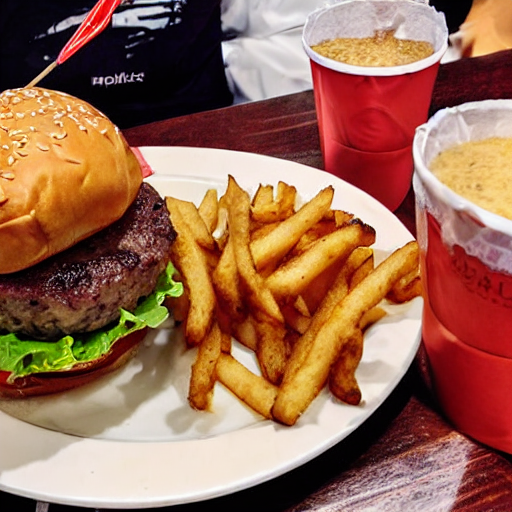


Generating image for: 'a plate of crispy fries, western food, high quality photograph'


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: /content/generated_plate_of_crispy_fries.png


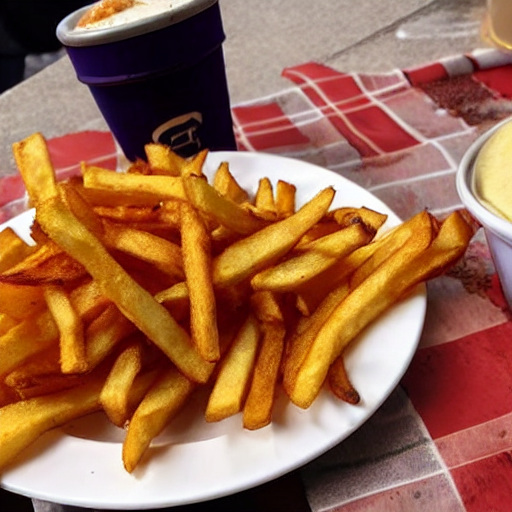


Generating image for: 'a hot dog with toppings, western food, high quality photograph'


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: /content/generated_hot_dog_with_toppings.png


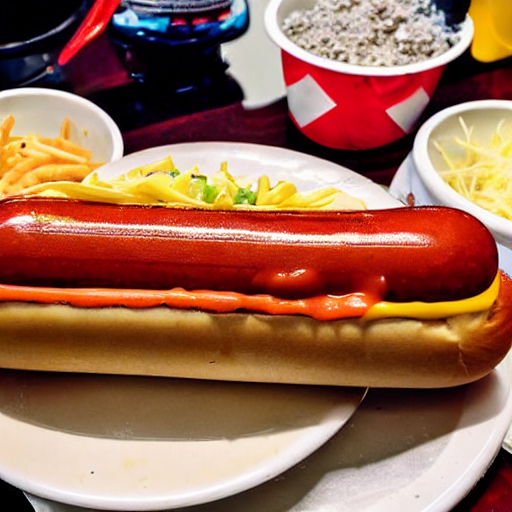


Generating image for: 'a slice of pizza, western food, high quality photograph'


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: /content/generated_slice_of_pizza.png


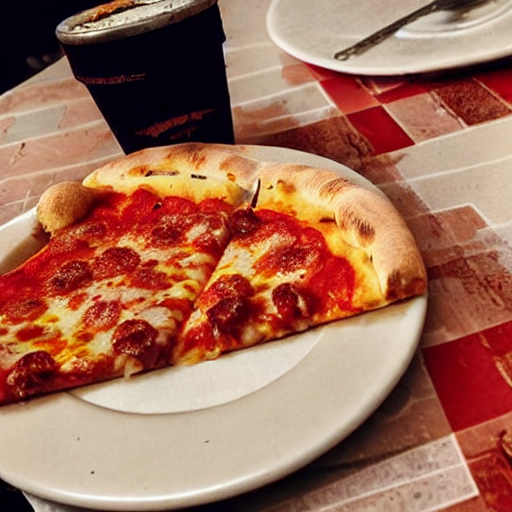

--- Testing completed ---


In [27]:
# Test the model
print("--- Testing the fine-tuned model ---")

test_prompts = [
    "a delicious burger, western food, high quality photograph",
    "a plate of crispy fries, western food, high quality photograph",
    "a hot dog with toppings, western food, high quality photograph",
    "a slice of pizza, western food, high quality photograph"
]

for prompt in test_prompts:
    print(f"\nGenerating image for: '{prompt}'")
    try:
        # Try the pipeline method first
        generated_image = generate_food_image(prompt)

        # Save the image
        safe_filename = prompt.split(',')[0].replace(' ', '_').replace('a_', '')
        image_path = f"/content/generated_{safe_filename}.png"
        generated_image.save(image_path)
        print(f"Image saved to: {image_path}")

        # Display in Colab
        from IPython.display import display
        display(generated_image)

    except Exception as e:
        print(f"Pipeline method failed: {str(e)}")
        print("Trying manual generation method...")

        try:
            # Try manual method as fallback
            generated_image = generate_food_image_manual(prompt)

            # Save the image
            safe_filename = prompt.split(',')[0].replace(' ', '_').replace('a_', '')
            image_path = f"/content/generated_manual_{safe_filename}.png"
            generated_image.save(image_path)
            print(f"Image saved to: {image_path}")

            # Display in Colab
            display(generated_image)

        except Exception as e2:
            print(f"Manual method also failed: {str(e2)}")

print("--- Testing completed ---")


--- Interactive Mode ---
Test your fine-tuned model with custom prompts!
Tips for better results:
- Be specific: 'a juicy cheeseburger with lettuce and tomato'
- Add style words: 'restaurant quality', 'professional photography'
- Mention food type: 'american food', 'fast food', 'gourmet'
------------------------------------------------------------

Enter your prompt for image generation (type 'quit' to exit): cheese pizza
Generating image for: 'cheese pizza, western food, high quality photograph'


  0%|          | 0/50 [00:00<?, ?it/s]

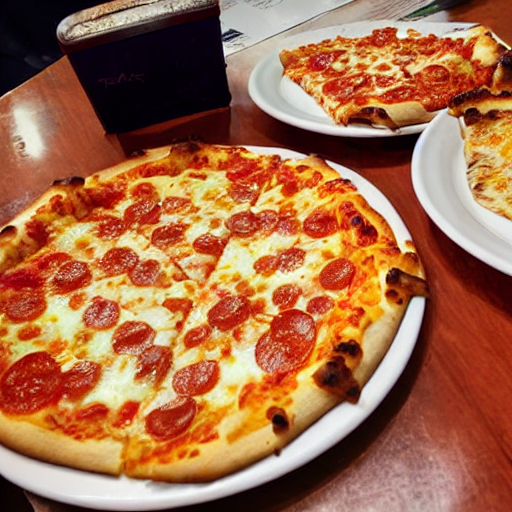

Save this image? (y/n): n
Satisfied with this result? This helps decide if we should save the model (y/n): y
Great! Consider saving the model after testing.

Enter your prompt for image generation (type 'quit' to exit): egg fried rice
Generating image for: 'egg fried rice, western food, high quality photograph'


  0%|          | 0/50 [00:00<?, ?it/s]

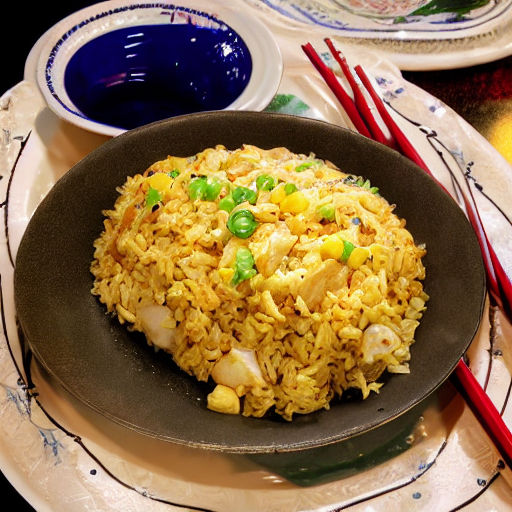

Save this image? (y/n): n
Satisfied with this result? This helps decide if we should save the model (y/n): y
Great! Consider saving the model after testing.

Enter your prompt for image generation (type 'quit' to exit): steamed momos
Generating image for: 'steamed momos, western food, high quality photograph'


  0%|          | 0/50 [00:00<?, ?it/s]

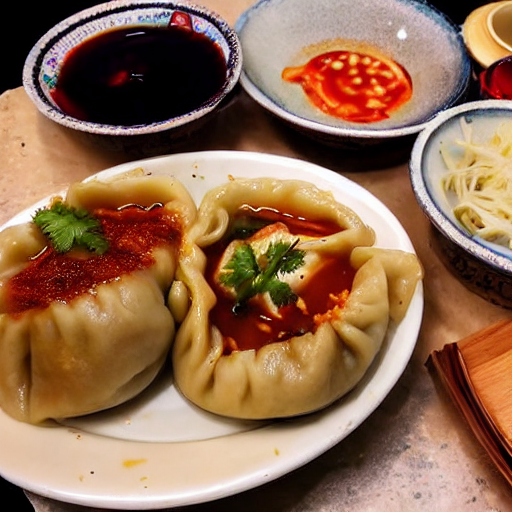

Save this image? (y/n): n
Satisfied with this result? This helps decide if we should save the model (y/n): y
Great! Consider saving the model after testing.

Enter your prompt for image generation (type 'quit' to exit): quit
--- Interactive testing ended ---


In [28]:
# Interactive testing
print("\n--- Interactive Mode ---")
print("Test your fine-tuned model with custom prompts!")
print("Tips for better results:")
print("- Be specific: 'a juicy cheeseburger with lettuce and tomato'")
print("- Add style words: 'restaurant quality', 'professional photography'")
print("- Mention food type: 'american food', 'fast food', 'gourmet'")
print("-" * 60)

while True:
    test_prompt = input("\nEnter your prompt for image generation (type 'quit' to exit): ")
    if test_prompt.lower() == 'quit':
        break

    # Enhance the prompt if it's too simple
    enhanced_prompt = test_prompt
    if "food" not in test_prompt.lower() and len(test_prompt.split()) < 5:
        enhanced_prompt += ", western food, high quality photograph"

    print(f"Generating image for: '{enhanced_prompt}'")

    try:
        # Try the pipeline method first
        generated_image = generate_food_image(enhanced_prompt)

        # Display in Colab
        display(generated_image)

        # Ask if user wants to save this specific image
        save_choice = input("Save this image? (y/n): ")
        if save_choice.lower() == 'y':
            filename = input("Enter filename (without extension): ").strip()
            if filename:
                generated_image.save(f"/content/{filename}.png")
                print(f"✅ Image saved as {filename}.png")

        # Ask if satisfied with results for potential model saving
        satisfaction = input("Satisfied with this result? This helps decide if we should save the model (y/n): ")
        if satisfaction.lower() == 'y':
            print("Great! Consider saving the model after testing.")

    except Exception as e:
        print(f"❌ Pipeline method failed: {str(e)}")
        print("Trying manual generation method...")

        try:
            # Try manual method as fallback
            generated_image = generate_food_image_manual(enhanced_prompt)
            display(generated_image)

            # Same save option for manual method
            save_choice = input("Save this image? (y/n): ")
            if save_choice.lower() == 'y':
                filename = input("Enter filename (without extension): ").strip()
                if filename:
                    generated_image.save(f"/content/{filename}_manual.png")
                    print(f"✅ Image saved as {filename}_manual.png")

        except Exception as e2:
            print(f"❌ Both methods failed: {str(e2)}")
            print("There might be an issue with the model. Consider retraining.")

print("--- Interactive testing ended ---")

In [29]:
# --- 9. SAVE THE MODEL (Only if satisfied) ---
print("\n" + "="*60)
print("TRAINING AND TESTING COMPLETE!")
print("="*60)

save_model = input("\n🤔 Are you satisfied with the results and want to save the model? (y/n): ")

if save_model.lower() == 'y':
    print("--- Saving the fine-tuned model ---")

    # Save the LoRA weights
    unet.save_pretrained(output_dir)

    # Save the tokenizer and text encoder configuration
    tokenizer.save_pretrained(output_dir)

    # Save a simple info file about the model
    info_text = f"""Western Food Generator Model
Training completed with:
- {len(train_dataset)} images
- {num_train_epochs} epochs
- LoRA fine-tuning

To load this model later:
1. Load the base model: runwayml/stable-diffusion-v1-5
2. Load the LoRA weights from: {output_dir}
3. Apply LoRA to the UNet

Generated on: {pd.Timestamp.now()}
"""

    with open(os.path.join(output_dir, "model_info.txt"), "w") as f:
        f.write(info_text)

    print(f"✅ Model saved to: {output_dir}")
    print("✅ You can now use this model for generating Western food images!")

else:
    print("❌ Model not saved. You can:")
    print("1. Continue testing with different prompts")
    print("2. Retrain with different parameters")
    print("3. Try different prompting techniques")

print("\n🎉 Session complete! Your Western food generator is ready.")


TRAINING AND TESTING COMPLETE!

🤔 Are you satisfied with the results and want to save the model? (y/n): y
--- Saving the fine-tuned model ---
✅ Model saved to: /content/drive/MyDrive/CravingsGenerator/Western_model
✅ You can now use this model for generating Western food images!

🎉 Session complete! Your Western food generator is ready.
